In [1]:
library("dplyr")
library("ggplot2")  
# Adicionando o diretorio atual
setwd("../");


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [268]:
dataset <- read.csv(file="./base_traduzida.csv", header=TRUE, sep=",")
base <- subset (as.data.frame(dataset), select = -c(X))

short_names <- c("Preço", "Vendas", "Nota", "Núm. Notas", "Preço Varejo", "Nota Vendedor", "Notas Vendedor")

In [317]:
## Graficos e transformacoes auxiliares

# Aplicacao cartesiana de vetores de nomes e dados sobre a funcao func, retorna um data frame "matricial" linear
crossDataFrame <- function(arra, arrb, data_a, data_b, func_a, func_b)
{
    x = 1:(length(arra)*length(arrb))
    y = 1:(length(arra)*length(arrb))
    z = 1:(length(arra)*length(arrb))
    k = 1:(length(arra)*length(arrb))
    
    for(i in 1:length(arra))
    {
        for(j in 1:length(arrb))
        {
            x[(i-1)*length(arra) + j] = arra[i]
            y[(i-1)*length(arra) + j] = arrb[j]
            z[(i-1)*length(arra) + j] = func_a(data_a[i], data_b[j])
            k[(i-1)*length(arra) + j] = func_b(data_a[i], data_b[j])
        }
    }
    
    data.frame(x=x, y=y, z=z, k=k)
}

# Aplicacao linear de uma funcao sobre um vetor, retorna um data frame linear
linearDataFrame <- function(names_a, arr, func_a, func_b)
{
    y = 1:(length(names_a))
    z = 1:(length(names_a))
    
    for(i in 1:length(names_a))
    {
        y[i] = func_a(arr[i])
        z[i] = func_b(arr[i])
    }
    
    data.frame(x=names_a, y=y, z=z)
}

# Transforma um dataframe em um vetor de colunas, sim
dfArrayCols <- function(df)
{
    x = vector(mode = "list", length = ncol(df)) 
    for(i in 1:ncol(df))
    {
        x[i] = list(df[,i])
    }
    x
}

# Gera mapa de calor sobre um dataframe (x, y, z, k)
# e a configuracao de cores
heatMap <- function(map, scale_lab="")
{
    heat <- ggplot(map, aes(x, y)) + geom_tile(aes(fill = z))
    heat = heat + scale_fill_gradient(low = "#0000FF", high = "#EE6600", name=scale_lab) + theme(axis.title.y=element_blank(), axis.title.x=element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=16, face="bold"), axis.text.y = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
    heat + geom_text(aes(label=k))
}

# Retorna um a "cor" de um p-value
pvalueColors<- function(v)
{
    color <- "#000000"
    
    if(v < -log(0.1, 10)) 
        color = "#AA0000"
    else if(-log(0.1, 10) <= v && v < -log(0.05, 10))
        color = "#AAAA00"
    else if(-log(0.05, 10) <= v && v < -log(0.01, 10))
        color = "#00AA22"
    else if(-log(0.01, 10) <= v)
        color = "#00FF00"
    color
}

# Gera um barplot sobre um dataframe(x=dados eixo x, y= dados eixo y, z=labels)
barPlot <- function(df, ylimits, title="", xlab="", ylab="")
{
    bp <- ggplot(data=df, aes(x=x, y=y)) + geom_bar(stat="identity", fill=df$colors)
    bp = bp + labs(title=title, x=xlab, y = ylab) 
    bp = bp + geom_text(aes(label=z), vjust=1.6, color="black", size=3.5)
}


# Gera um barplot sobre um dataframe(x=dados eixo x, y= dados eixo y)
# especifico para pvalues
pvaluePlot <- function(df, title="", xlab="", ylab="")
{
    #df$z= 1:nrow(df)
    df$colors = unlist(lapply(df$y, pvalueColors))
    bp <- barPlot(df, c(-30, 1.0), title, xlab, ylab) + geom_hline(yintercept = -log(0.05, 10), col="black")
    bp
}

## Funcoes de apoio
    
# Funcao de string vazio
voidFunc <- function(a, b)
{
    v <- ""
    v
}

# Valor R de regressao linear simples
# a, b = colunas de um dataframe contendo os dados
funcLmR <- function(a, b)
{
    options(warn=-1) #desabilita avisos
    a = unlist(a)
    b = unlist(b)
    fit <- summary(lm(a ~ b))$r.squared
    fit = as.numeric(format(fit, digits=1, nsmall=2))
    options(warn=0) #re-abilita avisos
    fit
}

# Valor p de regressao linear simples
# a, b = colunas de um dataframe contendo os dados
funcLmPv <- function(a, b)
{
    options(warn=-1) #desabilita avisos
    a = unlist(a)
    b = unlist(b)
    fit <- summary(lm(a ~ b))$coefficients[2,4]
    options(warn=0) #re-abilita avisos
    ret <- as.numeric(format(-log(fit, 10), digits=1, nsmall=2))
    if(fit == 0)
        ret = 99
    ret
}  

# Valor W do teste de shapiro-wilk,
# a = coluna de um dataframe contendo os dados
funcShapW <- function(a)
{
    a = unlist(a)
    w <- shapiro.test(a)$statistic
    w = as.numeric(format(w, digits=1, nsmall=2))
    w
}

# Valor p do teste de shapiro-wilk,
# a = coluna de um dataframe contendo os dados
funcShapPv <- function(a)
{
    a = unlist(a)
    p <- shapiro.test(a)$p.value
    as.numeric(format(-log(p, 10), digits=1, nsmall=2))
    if(fit == 0)
        ret = 99
    ret
}

[1] 0
[1] 0.3253378
[1] 0.03396815
[1] 0.9396478
[1] 3.682878e-35
[1] 0.06170138
[1] 0.345718
[1] 0.3253378
[1] 0
[1] 0.117556
[1] 0
[1] 0.6164603
[1] 1.098422e-06
[1] 2.904487e-28
[1] 0.03396815
[1] 0.117556
[1] 0
[1] 0.03187159
[1] 0.3393451
[1] 1.416034e-21
[1] 0.1798133
[1] 0.9396478
[1] 0
[1] 0.03187159
[1] 0
[1] 0.03264209
[1] 1.843465e-08
[1] 2.279813e-25
[1] 3.682878e-35
[1] 0.6164603
[1] 0.3393451
[1] 0.03264209
[1] 0
[1] 0.03097477
[1] 0.2477555
[1] 0.06170138
[1] 1.098422e-06
[1] 1.416034e-21
[1] 1.843465e-08
[1] 0.03097477
[1] 0
[1] 5.606997e-08
[1] 0.345718
[1] 2.904487e-28
[1] 0.1798133
[1] 2.279813e-25
[1] 0.2477555
[1] 5.606997e-08
[1] 0


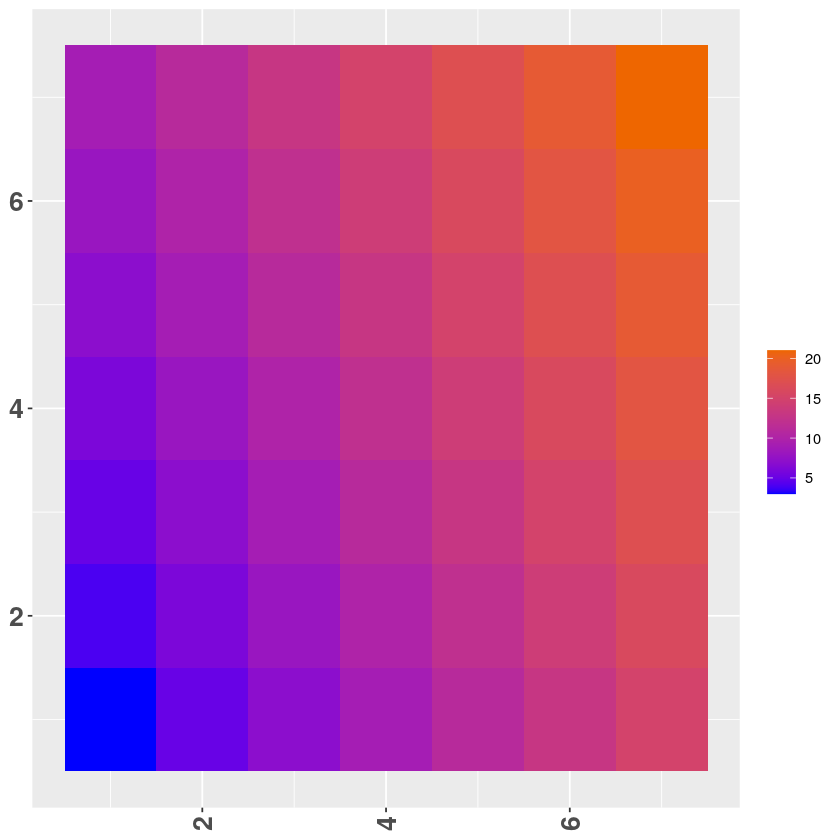

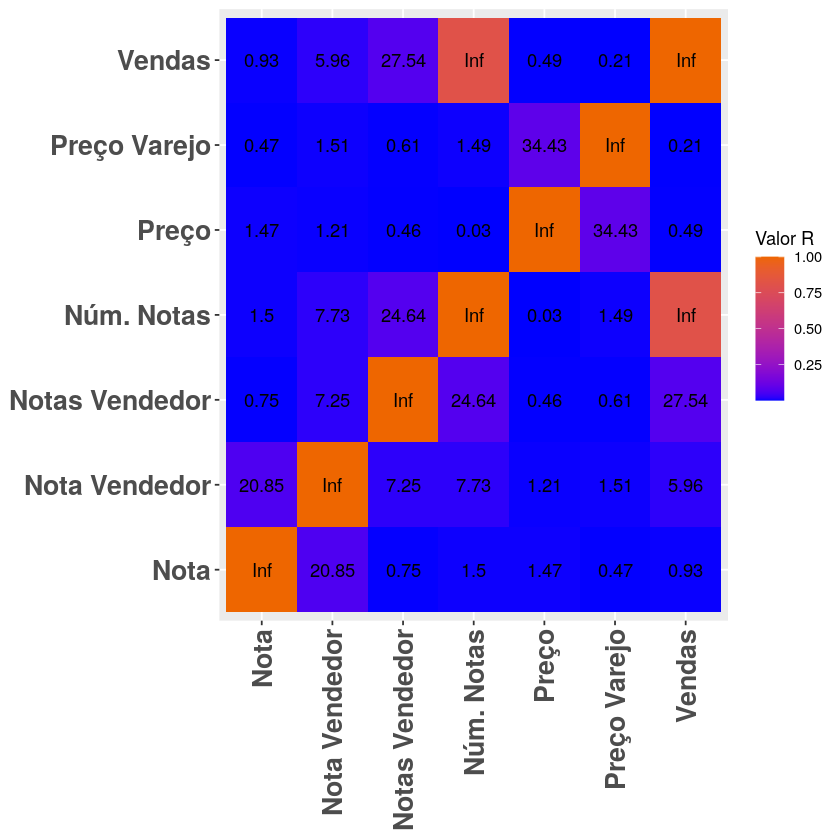

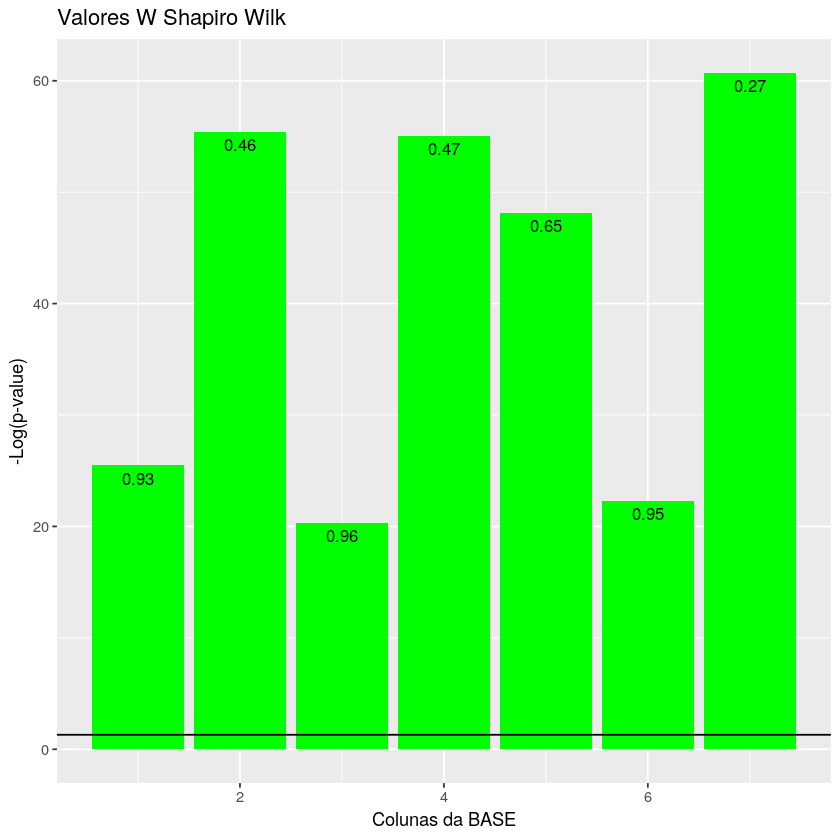

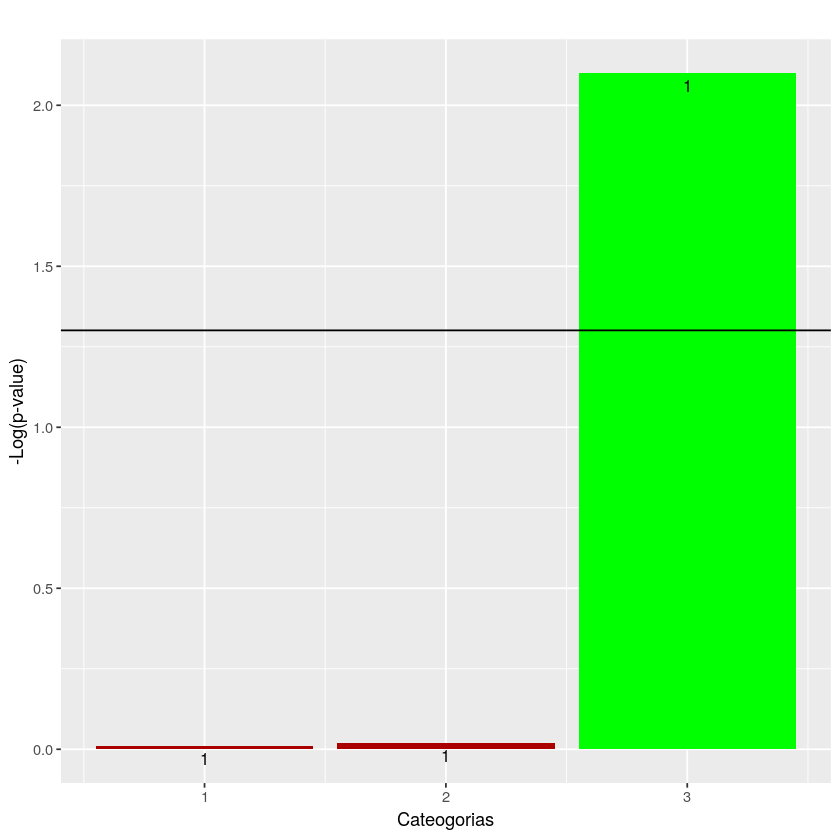

In [318]:
##### Exemplos #####

# Matriz qualquer
func <- function(a, b)
{
    min(a,b) + max(a,b) + mean(a,b)
}
m = crossDataFrame(1:ncol(base), 1:ncol(base), 1:ncol(base), 1:ncol(base), func, voidFunc)
heatMap(m) 
    
# Linearidade
df <- dfArrayCols(base)
m = crossDataFrame(short_names, short_names, df, df, funcLmR, funcLmPv)
heatMap(m,  "Valor R")

# Normalidade
df <- dfArrayCols(base)
m = linearDataFrame(1:ncol(base), df, funcShapPv, funcShapW)
pvaluePlot(m, "Valores W Shapiro Wilk", "Colunas da BASE", "-Log(p-value)")

# Exemplo de barras p-value
base_2 = data.frame(x=rnorm(5000, sd=1, mean=1), y=rnorm(5000, sd=1, mean=1), z=rnorm(5000, sd=1, mean=1))
m = linearDataFrame(1:ncol(base_2), base_2, func_b, func_a)
pvaluePlot(m, "", "Cateogorias", "-Log(p-value)")
##### Debug #####